In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import numpy as np

In [ ]:
# Load data
df = pd.read_excel('/content/sample_data/FEHDataStudent.xlsx', usecols=range(9))

In [ ]:
feature_columns = df.columns.drop('Index flood')

# Create an empty list to store the correlation values
correlations = []

# Iterate over each feature column
for feature in feature_columns:
    # Calculate the correlation between the feature and the predictor
    correlation = df[feature].corr(df['Index flood'])
    correlations.append(correlation)

# Create a DataFrame to store the feature names and their corresponding correlations
correlation_df = pd.DataFrame({'Feature': feature_columns, 'Correlation': correlations})

# Sort the DataFrame by the absolute value of the correlation in descending order
correlation_df = correlation_df.reindex(correlation_df['Correlation'].abs().sort_values(ascending=False).index)

# Display the correlation DataFrame
print(correlation_df)

   Feature  Correlation
0     AREA     0.722790
4      LDP     0.666511
5  PROPWET     0.404948
1  BFIHOST    -0.294033
7     SAAR     0.241418
6  RMED-1D     0.065423
2     FARL     0.021319
3    FPEXT     0.021301


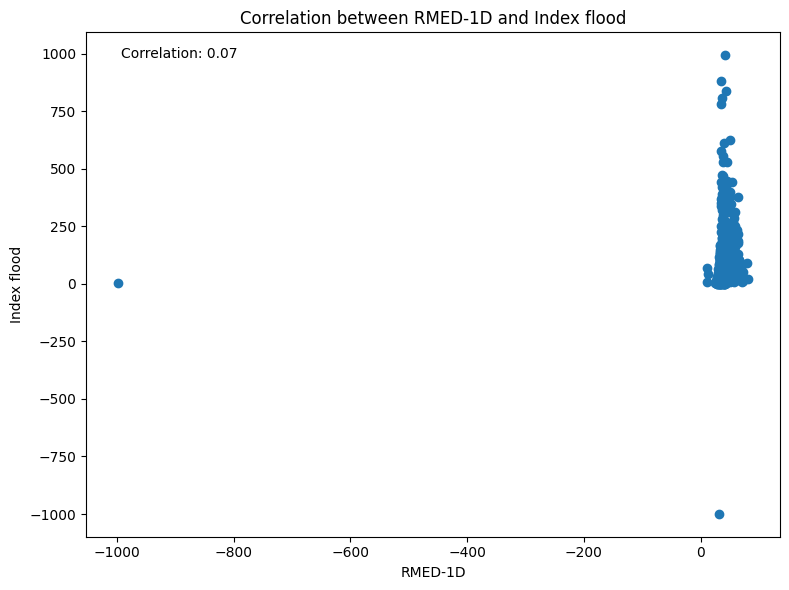

In [ ]:


# Assuming your data is stored in a pandas DataFrame called 'df'
# and the predictor column is named 'Index flood'

# Select the feature you want to visualize
feature_to_plot = 'RMED-1D'  # Replace with the desired feature name

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df[feature_to_plot], df['Index flood'])
plt.xlabel(feature_to_plot)
plt.ylabel('Index flood')
plt.title(f"Correlation between {feature_to_plot} and Index flood")

# Calculate the correlation coefficient
correlation = df[feature_to_plot].corr(df['Index flood'])

# Add the correlation coefficient to the plot
plt.annotate(f"Correlation: {correlation:.2f}", xy=(0.05, 0.95), xycoords='axes fraction')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Gets rid of errors in the data, such as 'a' and 'aaa'
df = df.apply(pd.to_numeric, errors='coerce')

# Preprocess data
# Replace NaNs with the mean of each column
df.fillna(df.mean(), inplace=True)

# Split values into predictors and predictand
y = df['Index flood']
X = df.drop(['Index flood', 'RMED-1D','FPEXT', 'FARL'], axis=1)


X_columns = X.columns.tolist()

# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split remaining data with 75% training and 25% validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Standardize the dataset
X_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
y_scaler = MinMaxScaler(feature_range=(0.1,0.9))

# Fit the scaler to training, validation and testing data
X_train = X_scaler.fit_transform(X_train)
X_valid = X_scaler.transform(X_valid)
X_test = X_scaler.transform(X_test)

# Reshape y to make it into a 2d array so that it can be fitted onto the scaler
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_valid = y_scaler.transform(y_valid.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

# Change back to a DataFrame as MinMaxScaler transforms the dataset into a numpy array
X_train = pd.DataFrame(X_train, columns=X_columns)
X_train.head()


,AREA,BFIHOST,LDP,PROPWET,SAAR
0,0.235620,0.351813,0.312893,0.468254,0.377333
1,0.113277,0.296891,0.178017,0.455556,0.321156
2,0.129892,0.264767,0.157950,0.544444,0.383733
3,0.106237,0.272021,0.138314,0.823810,0.884711
4,0.113282,0.374611,0.189521,0.214286,0.103911


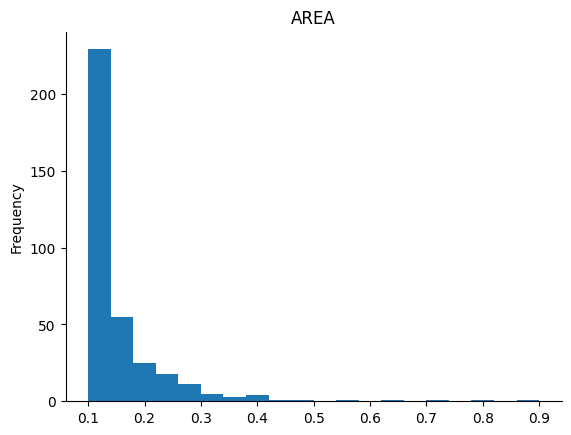

In [ ]:
# @title AREA

from matplotlib import pyplot as plt
X_train['AREA'].plot(kind='hist', bins=20, title='AREA')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Training function
class MLP:
    def __init__(self, input_size, hidden_size, learning_rate, momentum):

        # Seed the random number generator for reproducibility
        np.random.seed(42)

        # Initialize parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.output_size = 1

        # Initialize weights and biases
        self.weights_input_hidden = np.random.rand(self.input_size, self.hidden_size)
        self.weights_hidden_output = np.random.rand(self.hidden_size, self.output_size)
        self.bias_hidden = np.random.rand(1, self.hidden_size)
        self.bias_output = np.random.rand(1, self.output_size)

        # Intialise weight decay coefficient
        self.weight_decay_coefficient = 0.01

        self.momentum = momentum
        # Initialize the momentum terms
        self.v_weights_input_hidden = np.zeros((self.input_size, self.hidden_size))
        self.v_weights_hidden_output = np.zeros((self.hidden_size, self.output_size))
        self.v_bias_hidden = np.zeros((1, self.hidden_size))
        self.v_bias_output = np.zeros((1, self.output_size))

        self.training_loss = []
        self.validation_loss = []

    @staticmethod
    # Sigmoid activation function
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    # Sigmoid derivative
    def sigmoid_derivative(x):
        return x * (1 - x)

    @staticmethod
    # Function to calculate the root mean squared error
    def mean_squared_error(y_true, y_pred):
        mse = np.mean((y_true - y_pred) ** 2)
        mse = np.sqrt(mse)
        return mse

    def feed_forward(self, X):
        # Apply weights and biases to the input data
        self.hidden_layer_activation = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        # Apply activation function to the input data
        self.hidden_layer_output = self.sigmoid(self.hidden_layer_activation)
        self.output_layer_activation = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.bias_output
        self.predicted_output = self.sigmoid(self.output_layer_activation)
        # Return the predicted output
        return self.predicted_output

    def back_propagate(self, X, y):
        # Calculate error from predicted values to y
        error = y - self.predicted_output
        # Get sigmoid derivative of predicted value multiplied by error
        d_predicted_output = error * self.sigmoid_derivative(self.predicted_output)
        error_hidden_layer = d_predicted_output.dot(self.weights_hidden_output.T)
        d_hidden_layer = error_hidden_layer * self.sigmoid_derivative(self.hidden_layer_output)

        # Calculate the gradient updates based on sigmoid derivatives calculated
        grad_weights_hidden_output = self.hidden_layer_output.T.dot(d_predicted_output)
        grad_weights_input_hidden = X.T.dot(d_hidden_layer)
        grad_bias_output = np.sum(d_predicted_output, axis=0, keepdims=True)
        grad_bias_hidden = np.sum(d_hidden_layer, axis=0, keepdims=True)

        # Apply weight decay to the weights before the momentum update
        self.weights_hidden_output *= (1 - self.weight_decay_coefficient * self.learning_rate)
        self.weights_input_hidden *= (1 - self.weight_decay_coefficient * self.learning_rate)

        # Update the momentum terms
        self.v_weights_hidden_output = (self.momentum * self.v_weights_hidden_output) + (self.learning_rate * grad_weights_hidden_output)
        self.v_weights_input_hidden = (self.momentum * self.v_weights_input_hidden) + (self.learning_rate * grad_weights_input_hidden)
        self.v_bias_output = (self.momentum * self.v_bias_output) + (self.learning_rate * grad_bias_output)
        self.v_bias_hidden = (self.momentum * self.v_bias_hidden) + (self.learning_rate * grad_bias_hidden)

        # Update weights and biases with the momentum terms
        self.weights_hidden_output += self.v_weights_hidden_output
        self.weights_input_hidden += self.v_weights_input_hidden
        self.bias_output += self.v_bias_output
        self.bias_hidden += self.v_bias_hidden

    def train(self, X_train, y_train,  X_valid, y_valid, epochs):

        # Shuffle training data
        shuffle_indices = np.random.permutation(len(X_train))
        X_train = X_train[shuffle_indices]
        y_train = y_train[shuffle_indices]

        # Initiate variable to store value of the previous mse
        previous_val_mse = float('inf')
        for epoch in range(epochs):
            # Forward and backward propagation
            self.feed_forward(X_train)
            self.back_propagate(X_train, y_train)

            # Evaluating training and validation rmse for displaying
            train_mse = self.evaluate(X_train, y_train)
            val_mse = self.evaluate(X_valid, y_valid)
            self.training_loss.append(train_mse)
            self.validation_loss.append(val_mse)

            # Bold driver - only activated after the first epoch
            if epoch > 0 and epoch % 1:
                if val_mse < previous_val_mse:
                    # Increase learning rate
                    self.learning_rate *= 1.005
                else:
                    # Decrease learning rate
                    self.learning_rate *= 0.095
                previous_val_mse = val_mse  # Update the previous validation MSE

            # Print epoch error every 10 epochs
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, Training MSE: {train_mse}")
                print(f"Epoch {epoch}, Validation MSE: {val_mse}")


    def evaluate(self, X, y):
        # Get predictions by performing a forward pass on the current model
        predictions = self.feed_forward(X)
        # Obtain the root mean squared error
        mse = self.mean_squared_error(y, predictions)
        return mse

In [ ]:
# Replacing data as a numpy array
X_train = np.array(X_train)


In [ ]:
# Create the MLP object
mlp = MLP(input_size=5, hidden_size=8, learning_rate=0.01, momentum = 0.9)

# Train the MLP
epochs = 2000
mlp.train(X_train, y_train, X_valid, y_valid, epochs)


# Evaluate on test set
test_mse = mlp.evaluate(X_test, y_test)
print(f"Test MSE: {test_mse}")

Epoch 0, Training MSE: 0.37248948998624204
Epoch 0, Validation MSE: 0.3644422501968489
Epoch 1000, Training MSE: 0.03386936608783738
Epoch 1000, Validation MSE: 0.028588928717660042
Test MSE: 0.0290988521506142


In [ ]:
import matplotlib.pyplot as plt

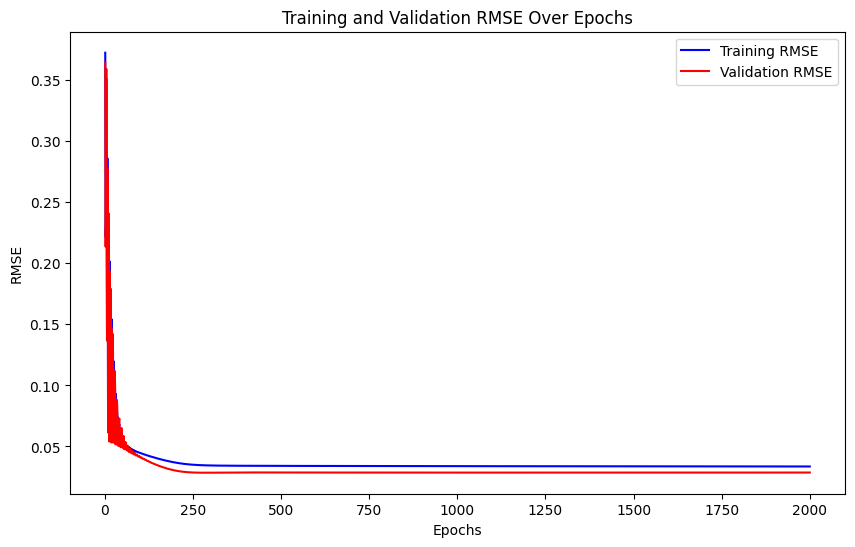

In [ ]:
epochs = list(range(1, len(mlp.training_loss) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, mlp.training_loss, 'b', label='Training RMSE')
plt.plot(epochs, mlp.validation_loss, 'r', label='Validation RMSE')
plt.title('Training and Validation RMSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Create an instance of the linear regression model
linear_model = LinearRegression()

# Train linear regression model
linear_model.fit(X_train, y_train)

# Make predictions on the validation set
predictions = linear_model.predict(X_valid)

# Calculate RMSE using the function from the MLP class
rmse = np.sqrt(mlp.mean_squared_error(y_valid, predictions))

# Print the RMSE
print("Linear Regression - RMSE:", rmse)

In [ ]:
# Plot RMSE at each epoch for both models
epochs = range(1, num_epochs + 1)
plt.axhline(y=rmse, color='r', linestyle='-', label='Linear Regression')
plt.plot(epochs, mlp.validation_loss, label='MLP')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()